## Packages
---
In this section, we import all the packages that will be used in this experiment

In [1]:
#Data Downloading
from urllib.request import urlopen
import os
import gzip

#Dataframe Packages
import pandas as pd
import dask.dataframe as dd

# Data Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt

# Training Data Preparation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Traditional Machine Learning Packages
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Deep Learning Packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import callbacks

# Saving ML Model
import joblib

import warnings
warnings.filterwarnings("ignore")

## Data Downloading
---
In this section, we will be using urllib to request and download job event and task event table from google cloud storage

In [ ]:
print('Job Event Table')
print('Download Started')
#job Usage Table
url1 = 'https://commondatastorage.googleapis.com/clusterdata-2011-2/job_events/part-'
url2 = '-of-00500.csv.gz'
for x in range(500):
    while True:
        try:
            url = url1+("%05d" % x)+url2
            fname = 'data/job_events/part-'+("%05d" % x)+'-of-00500.csv.gz'
            data = urlopen(url).read()
            with open(fname, 'wb') as f:
                f.write(data)
        except:
            continue
        break
print('Download Complete')

In [ ]:
print('Task Event Table')
print('Download Started')
#Task Usage Table
url1 = 'https://commondatastorage.googleapis.com/clusterdata-2011-2/task_events/part-'
url2 = '-of-00500.csv.gz'
for x in range(500):
    while True:
        try:
            url = url1+("%05d" % x)+url2
            fname = 'data/task_events/part-'+("%05d" % x)+'-of-00500.csv.gz'
            data = urlopen(url).read()
            with open(fname, 'wb') as f:
                f.write(data)
        except:
            continue
        break
print('Download Complete')

## Data Extraction
---
In this section, the data that is downloaded from the cloud will be extracted

In [ ]:
def gunzip(source_filepath, dest_filepath, block_size=65536):
    with gzip.open(source_filepath, 'rb') as s_file, \
            open(dest_filepath, 'wb') as d_file:
        while True:
            block = s_file.read(block_size)
            if not block:
                break
            else:
                d_file.write(block)

In [ ]:
path1 = 'data/job_events/part-'
path2 = '-of-00500.csv.gz'
path3 = '-of-00500.csv'
print('Extraction Started')
for x in range(500):
    spath = path1 + ('%05d' % x) + path2
    dpath = path1 + ('%05d' % x) + path3
    gunzip(spath, dpath)
    os.remove(spath)
print('Extraction Finished')

In [ ]:
path1 = 'data/task_events/part-'
path2 = '-of-00500.csv.gz'
path3 = '-of-00500.csv'
print('Extraction Started')
for x in range(500):
    spath = path1 + ('%05d' % x) + path2
    dpath = path1 + ('%05d' % x) + path3
    gunzip(spath, dpath)
    os.remove(spath)
print('Extraction Finished')

## Data Preparation

### Data Extraction
---
In this section, we load the data into the memory. We use dask dataframe as the amount of data is large and cannot be save at the RAM

In [2]:
job_event = dd.read_csv('data/job_events/*.csv', names=['Time','Missing Info','Job ID','Event Type','User Name','Scheduling Class','Job Name','Logical Job Name'],assume_missing=True)
task_event = dd.read_csv('data/task_events/*.csv', names=['Time','Missing Info','Job ID','Task Index','Machine ID','Event Type','User Name','Scheduling Class','Priority','CPU Request','Memory Request','Disk Space Request','Different Machine Restriction'],assume_missing=True)

In [3]:
job_event.head()

,Time,Missing Info,Job ID,Event Type,User Name,Scheduling Class,Job Name,Logical Job Name
0,0.0,NaN,3418309.0,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,IHgtoxEBuUTHNbUeVs4hzptMY4n8rZKLbZg+Jh5fNG4=,wAmgn2H74cdoMuSFwJF3NaUEaudVBTZ0/HaNZBwIpEQ=
1,0.0,NaN,3418314.0,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,L52XDyhi9x9ChmVBZ1qavOFmnzPeVsvQ2QyGmBZcV4s=,ShNjeaoUeqGV2i9WMKEX9HTeuc9K2Fdfovibt7Mp6qI=
2,0.0,NaN,3418319.0,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,vq0IN3BWEbkDjYgYvkrVyH6OWoUoDwFFf3j/syEZzLA=,1A2GM17AzHRcKJcJet/oIF7FOORyFcAOcUSpR9Fqou8=
3,0.0,NaN,3418324.0,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,X+Vce15Yu3BCKb7Ttc6hvINAzdfG3NtYEDNNsPdMGKo=,seczVo7MBfi/kH3+eH/40Hxs0l2YKFtXFnamcvMjSQI=
4,0.0,NaN,3418329.0,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,EeK3DUWYi1P0vgBTp7wZdUos8UKj/+/FqudTLohMQ9M=,OEeQsaVr4kdGHFwQ2liQlDZ18529HEMmu6B6/3K1cBA=


In [4]:
task_event.head()

,Time,Missing Info,Job ID,Task Index,Machine ID,Event Type,User Name,Scheduling Class,Priority,CPU Request,Memory Request,Disk Space Request,Different Machine Restriction
0,0.0,2.0,3418309.0,0.0,4.155527e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN
1,0.0,2.0,3418309.0,1.0,3.291507e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN
2,0.0,NaN,3418314.0,0.0,3.938719e+09,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,0.125,0.07446,0.000424,0.0
3,0.0,NaN,3418314.0,1.0,3.516186e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,0.125,0.07446,0.000424,0.0
4,0.0,2.0,3418319.0,0.0,4.310529e+08,0.0,70s3v5qRyCO/1PCdI6fVXnrW8FU/w+5CKRSa72xgcIo=,3.0,9.0,NaN,NaN,NaN,NaN


### Data Selection
---
In this section, we will select the data that will be use as a sample dataset for model training later on.

In [5]:
job_event = job_event[job_event['Time'] != 0]
job_event = job_event[job_event['Time'] < 604800600000]
job_event = job_event[job_event['Event Type'] > 1]
job_event = job_event[job_event['Event Type'] < 7]

In [6]:
task_event = task_event[task_event['Time'] != 0]
task_event = task_event[task_event['Time'] < 604800600000]
task_event = task_event[task_event['Event Type'] > 1]
task_event = task_event[task_event['Event Type'] < 7]

### Data Intergration
---
In this section, we perform data aggregation to find out the maximum amount of resource requested before we merge job event table and task event table.

In [7]:
task_event = task_event.groupby('Job ID').agg({'CPU Request':'max','Memory Request':'max','Disk Space Request':'max'})

In [8]:
job_event = job_event.merge(task_event, how='outer', on="Job ID", suffixes={' Job',' Task'})
job_event = job_event.dropna(subset=['Job Name','CPU Request'])

### Data Transformation
---
In this section, we grouped all the event type into two group which are success and failure. We mark success job as 1 and job failure as 0

In [9]:
job_event = job_event.replace({'Event Type':{2:0, 3:0, 4:1, 5:0, 6:0}})

Text(0.5, 1.0, 'Feature Correlating with Job Failure')

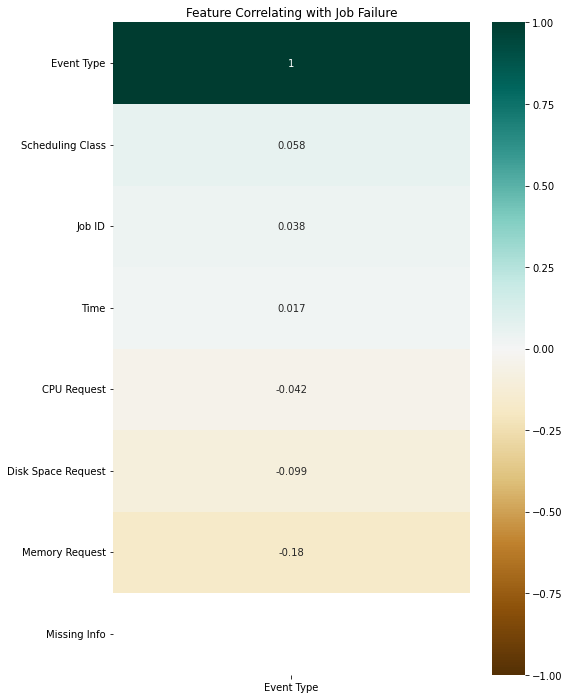

In [10]:
plt.figure(figsize=(8,12))
heatmap = sns.heatmap(job_event.corr()[['Event Type']].sort_values(by='Event Type', ascending=False).compute(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature Correlating with Job Failure')

In [11]:
job_event = job_event.drop(columns=['Time','Job ID','Missing Info','Job Name','Logical Job Name','User Name'])

In [12]:
job_event.head()

,Event Type,Scheduling Class,CPU Request,Memory Request,Disk Space Request
0,1.0,1.0,0.06250,0.006218,0.000045
1,1.0,1.0,0.06250,0.103400,0.000038
2,0.0,1.0,0.03125,0.009323,0.000154
3,1.0,1.0,0.01250,0.028630,0.000077
4,1.0,1.0,0.03125,0.011250,0.000011


In [13]:
job_event.to_csv('Selected Job.csv', single_file=True)

['d:/ADMIN/Documents/FYP/Selected Job.csv']

## Modelling
---

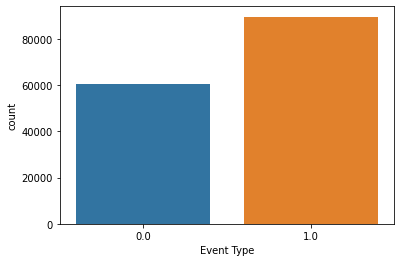

In [14]:
sns.countplot(data=job_event.compute(),x='Event Type')
plt.show()

In [15]:
x = job_event.drop(columns=['Event Type']).compute()
y = job_event['Event Type'].compute()

### SMOTE
---
In this section, we use SMOTE function to generate synthetic data to solve the class imbalance before we start the model training

In [16]:
sampling_method = SMOTE()
x,y = sampling_method.fit_resample(x,y)
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3)

### Traditional Machine Learning Model

#### Logistic Regression

In [17]:
Logistic_Regression = LogisticRegression(max_iter=10000000)
Logistic_Regression.fit(X_train, Y_train.values.ravel())
joblib.dump(Logistic_Regression, 'Logistic Regression.model')

['Logistic Regression.model']

#### Decision Tree

In [18]:
Decision_Tree = DecisionTreeClassifier()
Decision_Tree.fit(X_train, Y_train)
joblib.dump(Decision_Tree, 'Decision Tree.model')

['Decision Tree.model']

#### Random Forest

In [19]:
Random_Forest = RandomForestClassifier()
Random_Forest.fit(X_train, Y_train.values.ravel())
joblib.dump(Random_Forest, 'Random Forest.model')

['Random Forest.model']

#### Gradient Boosting

In [20]:
Gradient_Boosting = GradientBoostingClassifier()
Gradient_Boosting.fit(X_train, Y_train.values.ravel())
joblib.dump(Gradient_Boosting, 'Gradient Boosting.model')

['Gradient Boosting.model']

#### Extreme Gradient Boosting

In [21]:
XG_Boost = XGBClassifier()
XG_Boost.fit(X_train, Y_train.values.ravel())
joblib.dump(XG_Boost, 'Extreme Gradient Boosting.model')

[13:02:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['Extreme Gradient Boosting.model']

### Deep Learning Model

In [22]:
earlystopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 10, restore_best_weights = True)

#### Single Layer LSTM

In [ ]:
LSTM1 = Sequential()

LSTM1.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1)))
LSTM1.add(Dropout(0.2))

LSTM1.add(Dense(units = 1))

LSTM1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

LSTM1.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping])

LSTM1.save('LSTM1.keras')

#### Bi-Layer LSTM

In [ ]:
LSTM2 = Sequential()

LSTM2.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM2.add(Dropout(0.2))

LSTM2.add(LSTM(units = 50))
LSTM2.add(Dropout(0.2))

LSTM2.add(Dense(units = 1))

LSTM2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

LSTM2.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping])

LSTM2.save('LSTM2.keras')

#### Tri-Layer LSTM

In [ ]:
LSTM3 = Sequential()

LSTM3.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
LSTM3.add(Dropout(0.2))

LSTM3.add(LSTM(units = 50, return_sequences = True))
LSTM3.add(Dropout(0.2))

LSTM3.add(LSTM(units = 50))
LSTM3.add(Dropout(0.2))

LSTM3.add(Dense(units = 1))

LSTM3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy'])

history3 = LSTM3.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs=100, callbacks=[earlystopping] )

LSTM3.save('LSTM3.keras')